# MNIST classification

- https://en.wikipedia.org/wiki/MNIST_database

1. Naive-Bayes Classifier
    - skip. Less interesting. Maybe later.
2. Neural Netowrk
    - mini-batch

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sklearn

print('numpy: ', np.__version__)
print('sklearn: ', sklearn.__version__)

numpy:  1.16.6
sklearn:  0.22.2.post1


## Dataset can be obtained directly from `torchvision`

In [2]:
mnist_train = torchvision.datasets.MNIST(root='../data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='../data', train=False, download=True)

len(mnist_train), len(mnist_test)

(60000, 10000)

### Returned are PIL Image and target label

<PIL.Image.Image image mode=L size=28x28 at 0x1FBB58F4AC8> 5


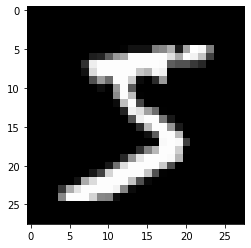

In [3]:
im, label = mnist_train[0]
plt.imshow(im, cmap='gray')
print(im, label)

### Convert to Tensor and A Custom torchvision.transformation for Binarization

In [4]:
class MyBinarization:
    """ convert a gray scale tensor [0, 1] to binary tensor of {0., 1.}"""
    def __init__(self, threshold=0.5):
        self.threshold=threshold
        
    def __call__(self, im):
        bright = im > self.threshold
        im[bright] = 1.
        im[~bright] = 0.
        return im

data_transform = torchvision.transforms.Compose([#transforms.Grayscale(), 
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Lambda(lambda im: (im>0.5).float()), # another way to do binarizaiton
                                     #MyBinarization() ,
                                     torchvision.transforms.Lambda(lambda im: im.reshape(-1)) # 
                                    ])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!


(torch.Size([784]), torch.float32, 5, array([0., 1.], dtype=float32), int, 784)

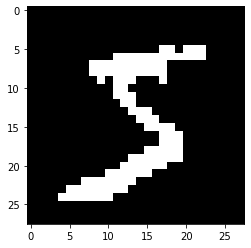

In [5]:
im, label = mnist_train[0]
plt.imshow(im.reshape(28,28), cmap='gray')
im.shape, im.dtype, label, np.unique(im), type(label), 28*28

## Tensor --> Numpy

In [6]:
def get_mnist_data(ds):
    x = np.empty((len(ds), 784))
    y = np.empty(len(ds),dtype=np.int64)
    for i in range(x.shape[0]):
        x[i,:], y[i] = ds[i]
    return x, y

In [7]:
%%time
Xtrain, ytrain = get_mnist_data(mnist_train)
Xtest,  ytest  = get_mnist_data(mnist_test)

Wall time: 6.68 s


## Bernoulli Naive Bayes
- https://github.com/dsgiitr/d2l-pytorch/blob/master/Ch04_The_Preliminaries_A_Crashcourse/Naive_Bayes_Classification.ipynb

In [8]:
# The count is 1 by default for numerical stabilization to automatically deal with 0-count cases.

xcount = torch.ones((im.reshape(-1).shape[0],10)).float()
ycount = torch.ones((10))

for im, label in mnist_train:
    xcount[:,label] += im.reshape(-1)
    ycount[label] += 1
#

In [9]:
py = ycount / ycount.sum()
px = xcount / ycount.unsqueeze(0) # each row is divided by ycount

- For example, px[300,:] shows the Bernoulli probability at the location 300 for the class labels.
- px[300,**k**] is the probability of being a bright pixel at the location 300 provided the class is **k**

In [10]:
px[300,:]

tensor([0.6437, 0.0114, 0.3167, 0.1797, 0.3377, 0.1046, 0.0781, 0.4349, 0.4508,
        0.3057])

In [11]:
py

tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])

Class Conditional Probabilities: 


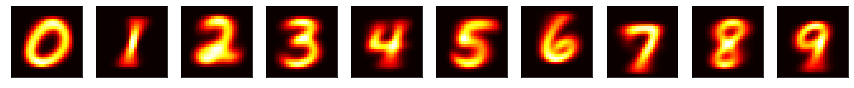

Class Prior Probabilities:
  tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])


In [12]:
fig, axes = plt.subplots(1,10, figsize=(15,10))
print('Class Conditional Probabilities: ')
for i in range(10):
    axes[i].imshow(px[:,i].reshape(28,28).numpy(), cmap='hot')
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)
plt.show()
print('Class Prior Probabilities:\n ', py)

* Notice that the images are well aligned within classes.

In [13]:
np.unique(mnist_train.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

## Now let's make a random sample of a number.

In [14]:
def sample(n, px):
    probs = px[:,n] # Bernoulli probability for each pixel, the probability that a sample has 1 as the outcome.
    qrobs = 1 - probs # the probability that a sample has 0 as the outcome
#     print(probs.shape)
    result = torch.empty_like(probs)
    for i in range(probs.shape[0]):
        r = torch.rand(1)
        if r < qrobs[i]:
            result[i] = 0.
        else:
            result[i] = 1.
    return result

In [15]:
def plot_samples(sample_number=0, n_imgs=10, nrows=3):
    fig, axes = plt.subplots(nrows, n_imgs, figsize=(15,4))
    for i, ax in enumerate(axes.flatten()):
        if i == 0:
            ax.imshow(px[:,sample_number].reshape(28,28), cmap='gray')
        else:
            s = sample(sample_number, px)
            ax.imshow(s.numpy().reshape(28,28), cmap='gray');
        ax.set_xticks([])
        ax.set_yticks([])

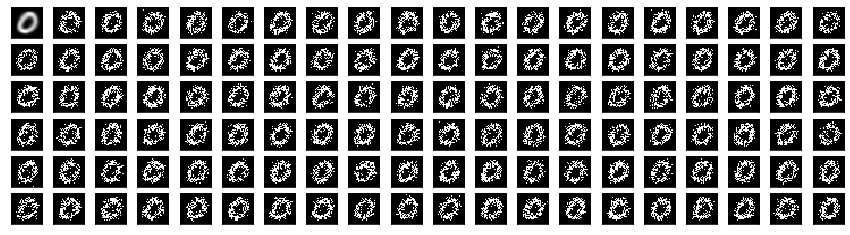

In [16]:
plot_samples(0, 20, 6)

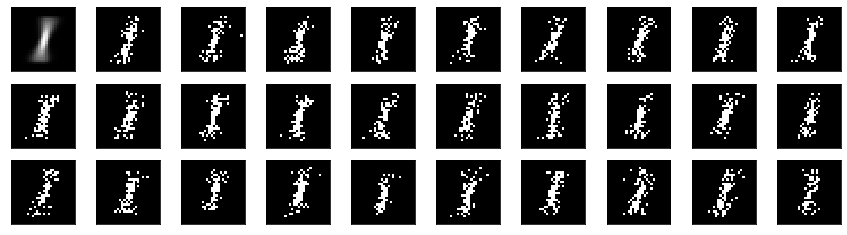

In [17]:
plot_samples(1)

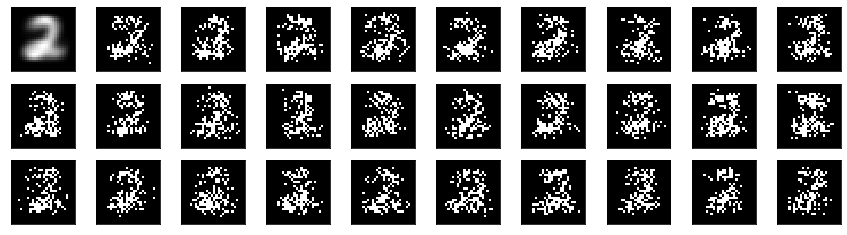

In [18]:
plot_samples(2)

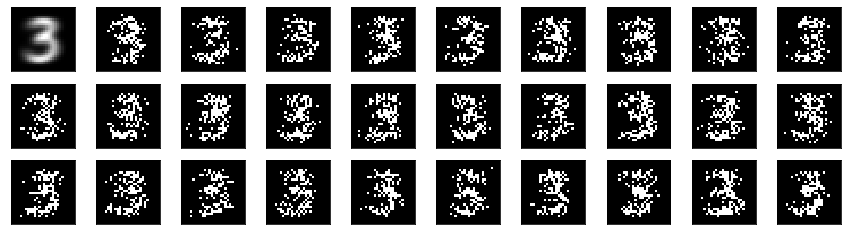

In [19]:
plot_samples(3)

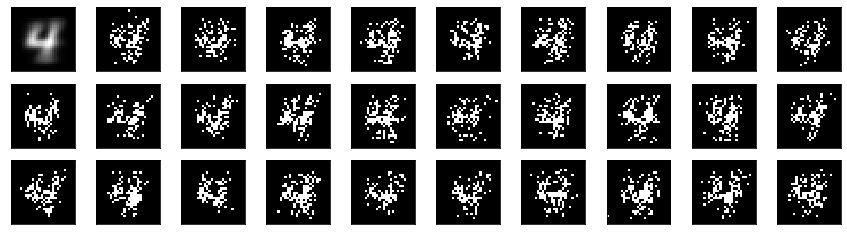

In [20]:
plot_samples(4)

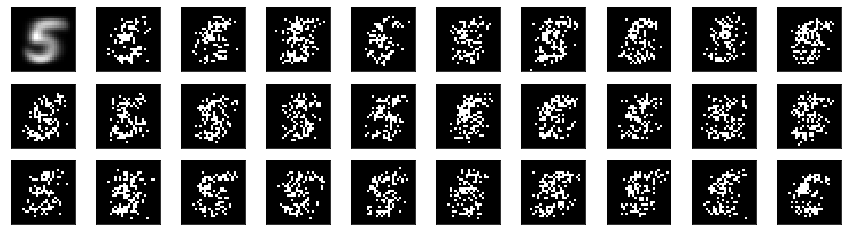

In [21]:
plot_samples(5)

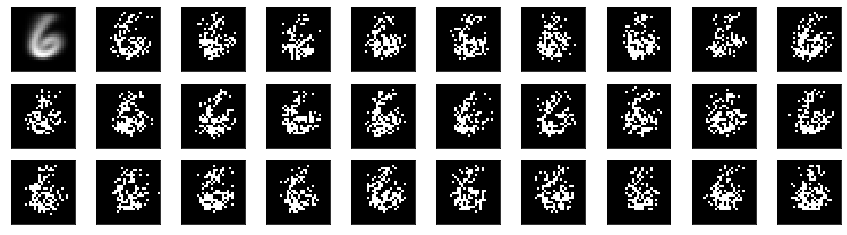

In [22]:
plot_samples(6)

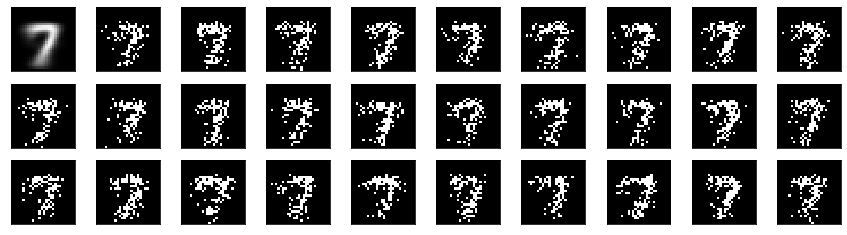

In [23]:
plot_samples(7)

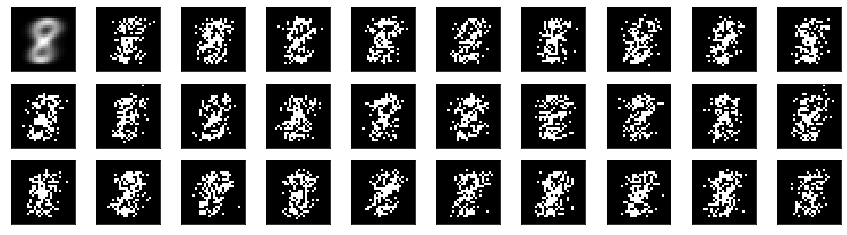

In [24]:
plot_samples(8)

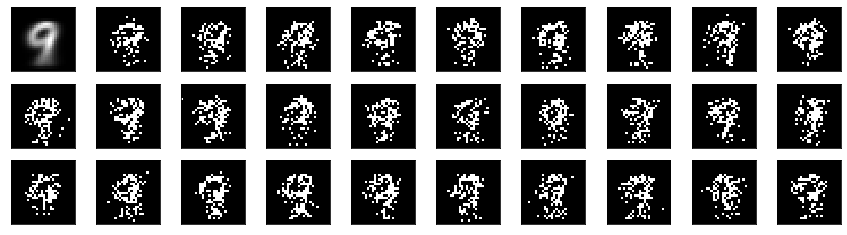

In [25]:
plot_samples(9)

## Summary
- Pixel-wise independent assumption leads to Bernoulli distribution.
- Probability can be easily computed.
- The samples from Bernoulli model are weird.

## Bernoulli Naive Bayes

$$
    \begin{align}
        P(Y=0|X=x) = \frac{P(x|Y=0)P(Y=0)}{\sum_k P(x|Y=k)P(Y=k)}
    \end{align}
$$

In [60]:
%%time

log_px = np.log(px.numpy())
log_qx = np.log(1-px.numpy())
log_py = np.log(py.numpy())

def log_likeli(x,y):
    m = x*log_px[:,y] + (1.-x)*log_qx[:,y]
    return m.sum()

def log_P(y):
    return log_py[y]

n_correct = 0
for tensor, label in mnist_test:
    x = tensor.numpy()
    log_posterior = np.zeros(10)
    for y in range(10):
        log_posterior[y] = log_likeli(x, y) + log_P(y)  # P(Y=y|X=x)
    #
    log_posterior -= log_posterior.sum()  # <-- this line is not necessary for argmax() operation
    pred_label = np.argmax(log_posterior)
#     print(log_posterior, pred_label)
    
    if pred_label == label:
        n_correct += 1
#     break
print('accuracy: ', n_correct/len(mnist_test))

accuracy:  0.8426
Wall time: 1.96 s


In [61]:
%%time

log_px = np.log(px.numpy())
log_qx = np.log(1. - px.numpy())
log_py = np.log(py.numpy())

n_correct = 0
for tensor, label in mnist_test:
    x = tensor.numpy()
    log_posterior = np.dot(log_px.T, x) + np.dot(log_qx.T, 1. - x) + log_py
    log_posterior -= log_posterior.sum()
    pred_label = np.argmax(log_posterior)
    
    if pred_label == label:
         n_correct += 1
#
print('accuracy: ', n_correct/len(mnist_test))

accuracy:  0.8426
Wall time: 1.12 s


In [62]:
def get_predict(testdataset):
    pred_label = []
    for  tensor, label in testdataset:
        x = tensor.numpy()
        log_posterior = np.dot(log_px.T, x) + np.dot(log_qx.T, 1. - x) + log_py
        log_posterior -= log_posterior.sum()
        pred_label.append( np.argmax(log_posterior) )
        
    return np.array(pred_label)

In [63]:
my_pred = get_predict(mnist_test)
my_pred[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 4, 9], dtype=int64)

In [64]:
sum(my_pred == ytest)

8426

---
## sklearn 
- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html?highlight=bernoullinb

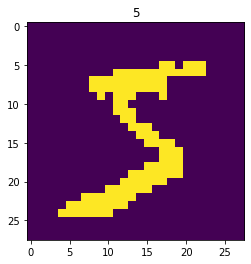

In [28]:
plt.imshow(Xtrain[0].reshape(28,28))
plt.title(f'{ytrain[0]}');

In [86]:
%%time
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB(binarize=0.5, alpha=1)
bnb.fit(Xtrain, ytrain)
bnb.score(Xtest, ytest)

Wall time: 604 ms


0.8427

In [83]:
bnb.class_log_prior_

array([-2.31550148, -2.18598795, -2.30960971, -2.28098669, -2.32927136,
       -2.40406426, -2.31634601, -2.25936597, -2.32773198, -2.31112142])

In [84]:
log_py

array([-2.3154993, -2.1860063, -2.3096085, -2.2809904, -2.3292668,
       -2.4040465, -2.3163438, -2.259373 , -2.3277278, -2.31112  ],
      dtype=float32)

In [85]:
bnb.feature_log_prob_.shape

(10, 784)

Class Conditional log-Probabilities: 


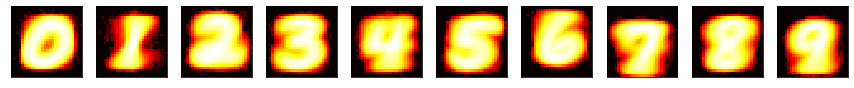

In [33]:
fig, axes = plt.subplots(1,10, figsize=(15,10))
print('Class Conditional log-Probabilities: ')
for i in range(10):
    axes[i].imshow(bnb.feature_log_prob_[i].reshape(28,28), cmap='hot')
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)
plt.show()

Class Conditional log-Probabilities: 


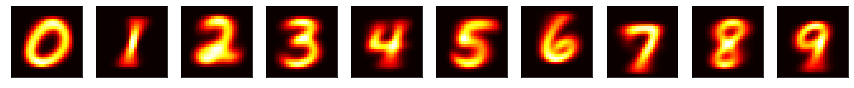

In [34]:
fig, axes = plt.subplots(1,10, figsize=(15,10))
print('Class Conditional log-Probabilities: ')
for i in range(10):
    axes[i].imshow(np.exp(bnb.feature_log_prob_[i]).reshape(28,28), cmap='hot')
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)
plt.show()

In [35]:
pred_y = bnb.predict(Xtest)

In [36]:
(pred_y == ytest).sum()

8427

---
End.

The index corresponding to discrepency:  2362


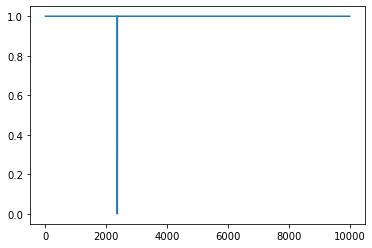

In [65]:
comp = my_pred == pred_y
idx = np.argmin(comp)
print('The index corresponding to discrepency: ', idx)
plt.plot(comp)

In [66]:
tensor, label = mnist_test[idx]
x = tensor.numpy()
log_posterior = np.dot(log_px.T, x) + np.dot(log_qx.T, 1. - x) + log_py
log_posterior -= log_posterior.sum()
pred_label = np.argmax(log_posterior)
print(f'log_post={log_posterior}  pred={pred_label}')

log_post=[1860.2184 2008.5162 1957.6809 1960.9628 1929.108  1956.4177 1878.6659
 1921.0297 2008.5157 1942.1438]  pred=1


In [59]:
bnb.predict(Xtest[idx:idx+1]), bnb.predict_log_proba(Xtest[idx:idx+1])

(array([8], dtype=int64),
 array([[-148.96568875,   -0.69870736,  -51.51924047,  -48.23734944,
          -80.09191495,  -52.7853669 , -130.52846675,  -88.17313307,
           -0.68761775,  -67.0575274 ]]))

In [67]:
bnb.class_log_prior_

array([-2.31550148, -2.18598795, -2.30960971, -2.28098669, -2.32927136,
       -2.40406426, -2.31634601, -2.25936597, -2.32773198, -2.31112142])

In [68]:
log_py

array([-2.3154993, -2.1860063, -2.3096085, -2.2809904, -2.3292668,
       -2.4040465, -2.3163438, -2.259373 , -2.3277278, -2.31112  ],
      dtype=float32)

In [69]:
bnb.class_log_prior_ - log_py

array([-2.17920218e-06,  1.83621917e-05, -1.24845835e-06,  3.66872581e-06,
       -4.57168123e-06, -1.77264520e-05, -2.22391181e-06,  6.97572615e-06,
       -4.18076879e-06, -1.39075217e-06])

In [72]:
bnb.coef_.shape, bnb.coef_

((10, 784), array([[-8.68693597, -8.68693597, -8.68693597, ..., -8.68693597,
         -8.68693597, -8.68693597],
        [-8.8164085 , -8.8164085 , -8.8164085 , ..., -8.8164085 ,
         -8.8164085 , -8.8164085 ],
        [-8.69282576, -8.69282576, -8.69282576, ..., -8.69282576,
         -8.69282576, -8.69282576],
        ...,
        [-8.74305305, -8.74305305, -8.74305305, ..., -8.74305305,
         -8.74305305, -8.74305305],
        [-8.67470963, -8.67470963, -8.67470963, ..., -8.67470963,
         -8.67470963, -8.67470963],
        [-8.69131455, -8.69131455, -8.69131455, ..., -8.69131455,
         -8.69131455, -8.69131455]]))

In [73]:
log_px

array([[-8.686768, -8.81626 , -8.692658, ..., -8.742893, -8.674539,
        -8.691147],
       [-8.686768, -8.81626 , -8.692658, ..., -8.742893, -8.674539,
        -8.691147],
       [-8.686768, -8.81626 , -8.692658, ..., -8.742893, -8.674539,
        -8.691147],
       ...,
       [-8.686768, -8.81626 , -8.692658, ..., -8.742893, -8.674539,
        -8.691147],
       [-8.686768, -8.81626 , -8.692658, ..., -8.742893, -8.674539,
        -8.691147],
       [-8.686768, -8.81626 , -8.692658, ..., -8.742893, -8.674539,
        -8.691147]], dtype=float32)

In [76]:
diff = log_px.T - bnb.coef_
diff.min(), diff.max()

(0.00014807390053839242, 0.00018464057747102913)

In [77]:
x = Xtest[idx]
x.shape

(784,)

In [80]:
np.dot(log_px.T, x) + np.dot(log_qx.T, 1-x)

array([-295.6059271 , -147.43761173, -198.14933181, -194.89618698,
       -226.70259972, -199.31814346, -277.15770332, -234.85088579,
       -147.29670383, -213.68510945])

In [ ]:
np.dot(bnb.coef_, x) + np.dot(bnb.coef_, 1-x)

In [87]:
bnb.coef_ - bnb.feature_log_prob_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])